In [6]:
import kagglehub
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.applications import VGG19
from keras.layers import Dense, Flatten
from keras.models import Model

In [7]:
PATH = "archive/"
print(PATH)

archive/


In [8]:
DATA_PATH = os.path.join(PATH, "CrashBest")
TABLE_PATH = os.path.join(PATH, "Crash_Table.csv")

TARGET_SIZE = (224, 224)

In [9]:
df = pd.read_csv(TABLE_PATH)
df.head()

,vidname,frame_1,frame_2,frame_3,frame_4,frame_5,frame_6,frame_7,frame_8,frame_9,...,frame_46,frame_47,frame_48,frame_49,frame_50,startframe,youtubeID,timing,weather,egoinvolve
0,1,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,285,0,Day,Normal,Yes
1,2,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,646,0,Day,Normal,Yes
2,3,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,972,0,Day,Normal,Yes
3,4,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1257,0,Day,Normal,Yes
4,5,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,462,10,Day,Snowy,Yes


In [10]:
df = df.drop(['startframe', 'youtubeID', 'egoinvolve'], axis=1)
df = pd.get_dummies(df, columns=['timing', 'weather'])
df = df.astype(int)
df.head()

,vidname,frame_1,frame_2,frame_3,frame_4,frame_5,frame_6,frame_7,frame_8,frame_9,...,frame_46,frame_47,frame_48,frame_49,frame_50,timing_Day,timing_Night,weather_Normal,weather_Rainy,weather_Snowy
0,1,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,0,1,0,0
1,2,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,0,1,0,0
2,3,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,0,1,0,0
3,4,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,0,1,0,0
4,5,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,0,0,0,1


In [11]:
df_sampled = df.sample(100, random_state=40)

In [12]:
def get_file_name(video_name, frame_name):
  return f"C_{video_name:06}_{frame_name:02}.jpg"

def get_video_frame_paths(video_name):
  frame_paths = []
  for i in range (1, 51):
    frame_path = os.path.join(DATA_PATH, get_file_name(video_name, i))
    frame_paths.append(frame_path)
  return frame_paths

In [13]:
video_names = []
raw_images =[]
labels = []
features = []

for idx, row in df_sampled.iterrows():
  frame_paths = get_video_frame_paths(row["vidname"])
  if all(os.path.exists(frame_path) for frame_path in frame_paths):
    for frame_path in frame_paths:
      image = cv2.imread(frame_path)
      raw_images.append(image)
      
    for i in range(1, 51):
      labels.append(row[f"frame_{i}"])
      video_names.append(row["vidname"])
      # features.append((row["timing_Day"],	row["timing_Night"],	row["weather_Normal"],	row["weather_Rainy"],	row["weather_Snowy"]))
      feature = row[["timing_Day", "timing_Night", "weather_Normal", "weather_Rainy", "weather_Snowy"]].values
      features.append(feature)      

print("Length of video_names: ", len(video_names))
print("Length of image_paths: ", len(raw_images))
print("Length of labels: ", len(labels))
print("Length of timings: ", len(features))

Length of video_names:  5000
Length of image_paths:  5000
Length of labels:  5000
Length of timings:  5000


In [14]:
def preprocess_image(image):
  image = cv2.resize(image, TARGET_SIZE)
  lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
  l, a, b = cv2.split(lab)
  clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
  l_clahe = clahe.apply(l)

  image_clahe = cv2.merge([l_clahe, a, b])
  image_clahe = cv2.cvtColor(image_clahe, cv2.COLOR_LAB2BGR)
  image_clahe = np.array(image).astype("float32") / 255.0
  return image_clahe

def preprocess_image_grayscale (image):
  image = cv2.resize(image, TARGET_SIZE)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
  gray_clahe = clahe.apply(gray)
  image_clahe = np.array(gray_clahe).astype("float32") / 255.0
  return image_clahe

In [15]:
preprocessed_images = []

for image in raw_images:
  image = preprocess_image_grayscale(image)
  preprocessed_images.append(image)

# flattened_images = [img.flatten() for img in preprocessed_images]
# combined_data = np.concatenate((np.array(preprocessed_images), np.array(features)), axis=1)

In [16]:
x_train, x_temp, y_train, y_temp = train_test_split(preprocessed_images, labels, test_size=0.2, random_state=40)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=40)

In [26]:
x_train_rgb = np.repeat(x_train, 3, axis=-1)
x_val_rgb = np.repeat(x_val, 3, axis=-1)
x_test_rgb = np.repeat(x_test, 3, axis=-1)

y_train_rgb = np.repeat(y_train, 3, axis=-1)
y_val_rgb = np.repeat(y_val, 3, axis=-1)
y_test_rgb = np.repeat(y_test, 3, axis=-1)

In [25]:
print(x_train_rgb.shape)

(4000, 224, 672)


In [18]:
model = VGG19(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
for layer in model.layers:
  layer.trainable = False

In [19]:
x = model.output
x = Flatten()(x)
x = Dense(50, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=model.input, outputs=output_layer)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │     1,254,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            5

 Total params: 21,278,885 (81.17 MB)

 Trainable params: 1,254,501 (4.79 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
EPOCHS = 10
BATCH_SIZE = 32

In [27]:
history = model.fit(np.array(x_train_rgb), np.array(y_train_rgb), epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(np.array(x_val_rgb), np.array(y_val_rgb)))

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 4000
'y' sizes: 12000


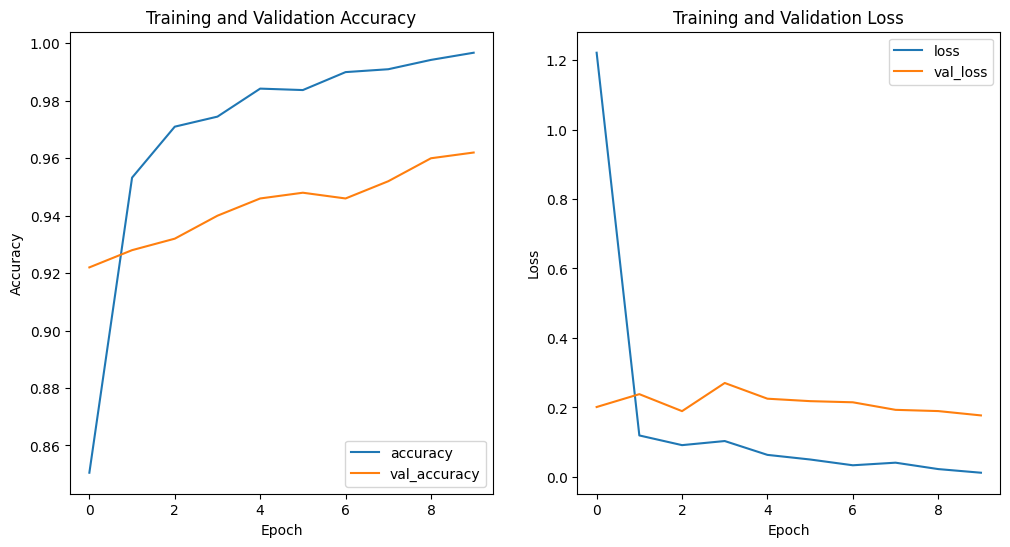

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(np.array(x_test), np.array(y_test), verbose=2)

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

16/16 - 33s - 2s/step - accuracy: 0.9680 - loss: 0.1434
Test accuracy: 0.9679999947547913
Test loss: 0.14337626099586487


In [ ]:
y_pred = model.predict(np.array(x_test))
y_pred = np.round(y_pred)

print("True Labels vs. Predicted Labels:")
for i in range(10):
  print(f"True Label: {int(y_test[i])}, Predicted Label: {int(y_pred[i])}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step
True Labels vs. Predicted Labels:
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 1
True Label: 1, Predicted Label: 1
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 1, Predicted Label: 0


C:\Users\jessi\AppData\Local\Temp\ipykernel_35380\1299305344.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"True Label: {int(y_test[i])}, Predicted Label: {int(y_pred[i])}")


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       358
           1       0.96      0.93      0.94       142

    accuracy                           0.97       500
   macro avg       0.96      0.96      0.96       500
weighted avg       0.97      0.97      0.97       500



<Figure size 800x600 with 0 Axes>

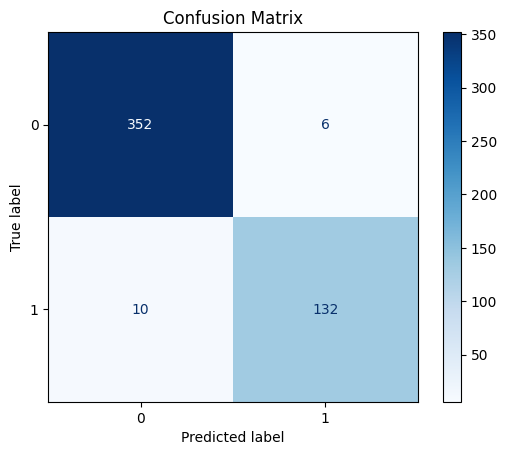

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
model.save('vgg_19.h5')